In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve, 
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import warnings

In [ ]:
print("numpy",np._version_)
print("pandas",pd._version_)
print("sklearn",sklearn._version_)
print("seaborn"seaborn._version_)
print("nltk",nltk._version_)
print("imblearn",imblearn._version_)
print("joblib",joblib._version_)
print("matplotlib",matplotlib._version_)

In [17]:
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2shan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2shan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\2shan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

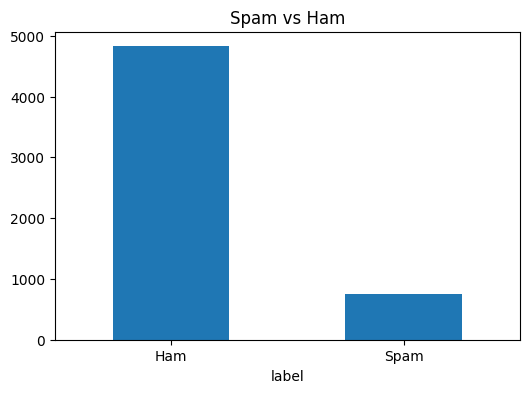

In [19]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', title='Spam vs Ham')
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

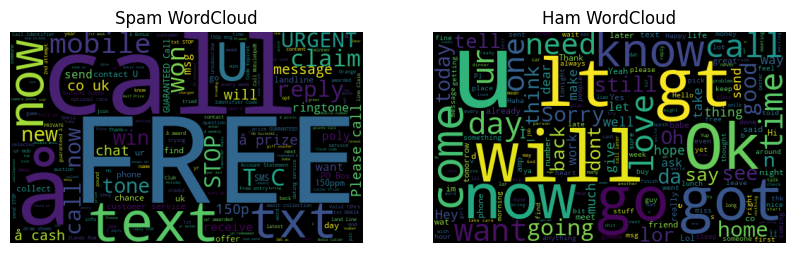

In [20]:
spam_words = ' '.join(list(df[df['label'] == 1]['text']))
ham_words = ' '.join(list(df[df['label'] == 0]['text']))

spam_wc = WordCloud(width=500, height=300).generate(spam_words)
ham_wc = WordCloud(width=500, height=300).generate(ham_words)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(spam_wc)
plt.axis('off')
plt.title('Spam WordCloud')

plt.subplot(1,2,2)
plt.imshow(ham_wc)
plt.axis('off')
plt.title('Ham WordCloud')
plt.show()


In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


In [22]:
df['clean_text'] = df['text'].apply(preprocess)

In [23]:
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [24]:
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

In [25]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', LogisticRegression())
])

params = {
    'tfidf__max_df': [0.7, 0.9],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1')
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=3000)),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1, 10], 'tfidf__max_df': [0.7, 0.9]},
             scoring='f1')

In [26]:
y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.7}

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.9847533632286996


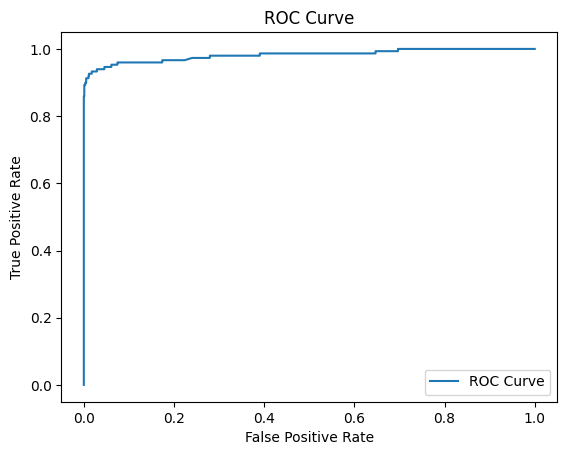

In [27]:
probs = grid.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [28]:
joblib.dump(grid.best_estimator_, 'spam_detector_model.pkl')

['spam_detector_model.pkl']

In [29]:
def predict_spam(text):
    model = joblib.load('spam_detector_model.pkl')
    clean = preprocess(text)
    return model.predict([clean])[0]

In [30]:
example = "Congratulations! You won a $1000 gift card. Click here to claim."
print("Prediction for example:", "Spam" if predict_spam(example) else "Ham")


Prediction for example: Spam
